In [1]:
# %% Setup -- import modules, etc.

# Standard modules
import os
import sys
import numpy as np
import pandas as pd

# Custom modules
sys.path.append('/Users/alandegenhart/src/')
import neuropy as neu
from neuropy.analysis import gpfa
import neuropy.temp as tmp

# Setup autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
# Define data paths
base_dir = os.path.join(os.sep, 'Volumes', 'Samsung_T5', 'Batista', 'Animals')
subject = 'Earl'
dataset = '20180927'
data_dir = os.path.join(
    base_dir, subject, dataset[0:4], dataset[4:6], dataset
)
save_dir = os.path.join(data_dir, 'translated', 'pandasData')
dataset_name = [
    'Earl20180927_04_condGridTask_01_SI_exportData.hdf',
    'Earl20180927_05_twoTargetABBA_rotated_01_SI_exportData.hdf'
]

# Load data
df_int = pd.read_hdf(os.path.join(save_dir, dataset_name[0]), 'df')
df_rot = pd.read_hdf(os.path.join(save_dir, dataset_name[1]), 'df')

# %% Load decoder and GPFA parameters

# Get decoder names
int_dec_path = os.path.join(data_dir, df_int['decoderName'].iloc[0] + '.mat')
rot_dec_path = os.path.join(data_dir, df_rot['decoderName'].iloc[0] + '.mat')

# Load decoding parameters and GPFA results
dec_int = neu.util.convertmat.convert_mat(int_dec_path)['bci_params']
dec_rot = neu.util.convertmat.convert_mat(rot_dec_path)['bci_params']
neu.el.proc.clean_bci_params(dec_int)
neu.el.proc.clean_bci_params(dec_rot)

# Define paths to GPFA data
gpfa_results_dir = os.path.join(data_dir, 'analysis', 'mat_results')
int_dec_num = 5  # Need to re-convert data to get this from the params
rot_dec_num = 10 # Need to re-convert data to get this from the params
int_gpfa_path = os.path.join(
    gpfa_results_dir,
    'run{:03d}'.format(int_dec_num),
    'gpfa_xDim{}.mat'.format(dec_int['xDim'])
)
rot_gpfa_path = os.path.join(
    gpfa_results_dir,
    'run{:03d}'.format(rot_dec_num),
    'gpfa_xDim{}.mat'.format(dec_rot['xDim'])
)
int_gpfa_path = os.path.join(gpfa_results_dir, int_gpfa_path)
rot_gpfa_path = os.path.join(gpfa_results_dir, rot_gpfa_path)

# Load GPFA data
gpfa_int = neu.util.convertmat.convert_mat(int_gpfa_path)['estParams']
gpfa_rot = neu.util.convertmat.convert_mat(rot_gpfa_path)['estParams']
neu.el.proc.clean_gpfa_params(gpfa_int)
neu.el.proc.clean_gpfa_params(gpfa_rot)

/Users/alandegenhart/src/neuropy/util/convertmat.py:160: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data_list = dataset.value
/Users/alandegenhart/src/neuropy/util/convertmat.py:157: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  for ref in dataset.value.flatten()


Check to make sure that re-decoded positions match those found online.

In [3]:
# Check re-decode accuracy (intuitive)
dif = neu.el.validation.redecode_cursor_pos(
    df_int['decodeSpikeCounts'], df_int['decodeState'], dec_int
)

# Check re-decode accuracy (rotated)
dif = neu.el.validation.redecode_cursor_pos(
    df_rot['decodeSpikeCounts'], df_rot['decodeState'], dec_rot
)

Redecode accuracy: 2.83e-14 (mean), 2.13e-13 (max)
Redecode accuracy: 1.95e-14 (mean), 1.42e-13 (max)


In [4]:
# Orthonormalize
C_orth, T, s, VH = gpfa.orthogonalize(gpfa_int['C'])

In [5]:
# Get neural trajectories
U = df_int['decodeSpikeCounts'].apply(
    neu.analysis.gpfa.extract_causal_traj, args=(dec_int,)
)
U.iloc[0].shape

# Transform to orthonormalized latents
U_orth = U.apply(lambda x: T @ x)
U_orth.iloc[0].shape

(10, 29)

In [8]:
# Get start and end target positions
start_pos = df_int['startPos']
end_pos = df_int['targPos']

# Define target combination
start_pos = np.concatenate(start_pos)
end_pos = np.concatenate(end_pos)
targ_comb = np.concatenate([start_pos, end_pos], axis=1)
uni_targ_comb = np.unique(targ_comb, axis=0)

In [99]:
start_cond = tmp.get_targ_cond(df_int['startPos'])
end_cond = tmp.get_targ_cond(df_int['targPos'])
targ_cond = [''.join([s, e]) for s, e in zip(start_cond, end_cond)]
mask = temp.get_targ_pairs(start_cond, end_cond)
col_map = temp.define_color_map()

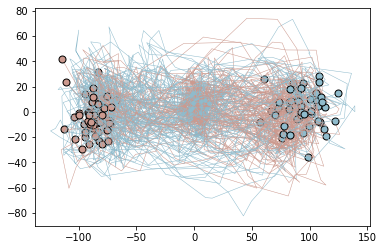

In [145]:
tmp.plot_traj(df_int['decodeState'][mask], pd.Series(targ_cond)[mask], col_map,
         col_mode='light',
         line_width=0.5,
         marker_size=7)

### Next steps
- Find trajectory onset and offset indices
- Add target plotting
- Outer wrapper to generate plots (create figure layout, etc.)
- Spatial average method
- Implement FlowField class
    - Fit method
    - Can have child classes that implement different methods
    - Voxel method
    - Distance-weighted average method
    - NN-based method
- `load_test.py` will need to be turned into a more standalone function to batch iterate over datasets
- Look into Pandas pickle warnings